[Sebastian Raschka](http://sebastianraschka.com)  
last updated: 05/28/2014

- [Open in IPython nbviewer](http://nbviewer.ipython.org/github/rasbt/One-Python-benchmark-per-day/blob/master/ipython_nbs/day4_2_cython_numba_parakeet.ipynb?create=1)  
- [Link to this IPython notebook on Github](https://github.com/rasbt/One-Python-benchmark-per-day/blob/master/ipython_nbs/day4_2_cython_numba_parakeet.ipynb)  
- [Link to the GitHub Repository One-Python-benchmark-per-day](https://github.com/rasbt/One-Python-benchmark-per-day)


<hr>
I would be happy to hear your comments and suggestions.  
Please feel free to drop me a note via
[twitter](https://twitter.com/rasbt), [email](mailto:bluewoodtree@gmail.com), or [google+](https://plus.google.com/118404394130788869227).
<hr>

# Day 4.2 - One Python Benchmark per Day

## Comparing (C)Python compilers - Cython vs. Numba on Bubblesort

<br>
**[-> skip to the results](#Results)**
<br>

<br>
<br>
I made some significant changes to the previous [Day 4 benchmark](http://nbviewer.ipython.org/github/rasbt/One-Python-benchmark-per-day/blob/master/ipython_nbs/day4_python_cython_numba.ipynb?create=1), thus I decided to make it a separate article:   
- improved the Bubblesort algorithm to avoid comparing already-sorted pairs  
- improved the Cython implementation (avoiding redundant conversion from memory view to array object)  
- focussed on only the optimized ("best") Cython and Numba implementations of Bubblesort

<br>
<br>

### Quick note about Bubblesort

I don't want to get into the details about sorting algorithms here, but there is a great report  
["Sorting in the Presence of Branch Prediction and Caches - Fast Sorting on Modern Computers"](https://www.cs.tcd.ie/publications/tech-reports/reports.05/TCD-CS-2005-57.pdf) written by Paul Biggar and David Gregg, where they describe and analyze elementary sorting algorithms in very nice detail (see chapter 4).   

And for a quick reference, [this website](http://www.sorting-algorithms.com/bubble-sort) has a nice animation of this algorithm.

A long story short: The "worst-case" complexity of the Bubblesort algorithm (i.e., "Big-O")  
 $\Rightarrow \pmb O(n^2)$

<br>
<br>

### Bubble sort implemented in (C)Python

In [34]:
def python_bubblesort(a_list):
    """ Bubblesort in Python for list objects. """
    length = len(a_list)
    swapped = 1
    for i in range(0, length):
        if swapped: 
            swapped = 0
            for ele in range(0, length-i-1):
                if a_list[ele] > a_list[ele + 1]:
                    temp = a_list[ele + 1]
                    a_list[ele + 1] = a_list[ele]
                    a_list[ele] = temp
                    swapped = 1
    return a_list

In [35]:
def python_bubblesort_ary(np_ary):
    """ Bubblesort in Python for NumPy arrays. """
    length = np_ary.shape[0]
    swapped = 1
    for i in range(0, length):
        if swapped: 
            swapped = 0
            for ele in range(0, length-i-1):
                if np_ary[ele] > np_ary[ele + 1]:
                    temp = np_ary[ele + 1]
                    np_ary[ele + 1] = np_ary[ele]
                    np_ary[ele] = temp
                    swapped = 1
    return np_ary

<br>
<br>

### Bubble sort implemented in Cython

Maybe we can speed things up a little bit via [Cython's C-extensions for Python](http://cython.org). Cython is basically a hybrid between C and Python and can be pictured as compiled Python code with type declarations.  
Since we are working in an IPython notebook here, we can make use of the very convenient *IPython magic*: It will take care of the conversion to C code, the compilation, and eventually the loading of the function.  

Note that the static type declarations that we add via `cdef` are note required for Cython to work, but it will speed things up tremendously.

In [36]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [37]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef cython_bubblesort(inp_ary):
    """ The Cython implementation of Bubblesort with NumPy memoryview."""
    cdef unsigned long length, i, swapped, ele, temp
    cdef long[:] np_ary = inp_ary
    length = np_ary.shape[0]
    swapped = 1
    for i in range(0, length):
        if swapped: 
            swapped = 0
            for ele in range(0, length-i-1):
                if np_ary[ele] > np_ary[ele + 1]:
                    temp = np_ary[ele + 1]
                    np_ary[ele + 1] = np_ary[ele]
                    np_ary[ele] = temp
                    swapped = 1
    return inp_ary

<br>
<br>

### Bubble sort implemented in Numba

Numba is using the [LLVM compiler infrastructure](http://llvm.org) for compiling Python code to machine code. Its strength is to work with NumPy arrays to speed-up the code. If you want to read more about Numba, please see refer to the original [website and documentation](http://numba.pydata.org/numba-doc/0.13/index.html).

In [38]:
from numba import jit as numba_jit
@numba_jit
def numba_bubblesort(np_ary):
    """ The NumPy implementation of Bubblesort on NumPy arrays."""
    length = np_ary.shape[0]
    swapped = 1
    for i in range(0, length):
        if swapped: 
            swapped = 0
            for ele in range(0, length-i-1):
                if np_ary[ele] > np_ary[ele + 1]:
                    temp = np_ary[ele + 1]
                    np_ary[ele + 1] = np_ary[ele]
                    np_ary[ele] = temp
                    swapped = 1
    return np_ary

<br>
<br>

## Verifying that all implementations work correctly

In [44]:
import random
import copy
import numpy as np
random.seed(4354353)

l = np.asarray([random.randint(1,1000) for num in range(1, 1000)])
l_sorted = np.sort(l)
for f in [python_bubblesort, python_bubblesort_ary, cython_bubblesort, numba_bubblesort]:
    assert(l_sorted.all() == f(copy.copy(l)).all())
print('Bubblesort works correctly')

Bubblesort works correctly


<br>
<br>

## Timing

In [ ]:
import timeit
import copy
import numpy as np

funcs = ['python_bubblesort',
         'python_bubblesort_ary',
         'cython_bubblesort',
         'numba_bubblesort'
         ]

orders_n = [10**n for n in range(1, 6)]
timings = {f:[] for f in funcs}

for n in orders_n:
    l = [np.random.randint(n) for num in range(n)]
    for f in funcs:
        l_copy = copy.deepcopy(l)
        if f != 'python_bubblesort':
            l_copy = np.asarray(l_copy)
        timings[f].append(min(timeit.Timer('%s(l_copy)' %f, 
                      'from __main__ import %s, l_copy' %f)
                              .repeat(repeat=3, number=10)))

<br>
<br>

### Setting up the plots

In [48]:
import platform
import multiprocessing
from cython import __version__ as cython__version__
from numba import __version__ as numba__version__

def print_sysinfo():
    
    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())
    print('Cython version  :', cython__version__)
    print('NumPy version   :', np.__version__)
    print('Numba version   :', numba__version__)
    
    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', multiprocessing.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [49]:
%matplotlib inline

In [52]:
import matplotlib.pyplot as plt

def plot(timings, title, ranked_labels, labels, orders_n):
    plt.rcParams.update({'font.size': 12})

    fig = plt.figure(figsize=(11,10))
    for lb in ranked_labels:
        plt.plot(orders_n, timings[lb], alpha=0.5, label=labels[lb], 
                 marker='o', lw=3)
    plt.xlabel('sample size n (items in the list)')
    plt.ylabel('time per computation in milliseconds')
    plt.xlim([min(orders_n) / 10, max(orders_n)* 10])
    plt.legend(loc=2)
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.show()

In [53]:
import prettytable

def summary_table(ranked_labels):
    fit_table = prettytable.PrettyTable(['n=%s' %orders_n[-1], 
                                         'bubblesort function' ,
                                         'time in millisec.',
                                         'rel. performance gain'])
    fit_table.align['bubblesort function'] = 'l'
    for entry in ranked_labels:
        fit_table.add_row(['', labels[entry[1]], round(entry[0]*100, 3), 
                           round(ranked_labels[0][0]/entry[0], 2)])
        # times 100 for converting from seconds to milliseconds: (time*1000 / 10-loops)
    print(fit_table)

<br>
<br>

## Results


Python version  : 3.5.2
compiler        : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
Cython version  : 0.24
NumPy version   : 1.11.2
Numba version   : 0.30.1+0.g8c1033f.dirty

system     : Linux
release    : 2.6.32-696.1.1.el6.x86_64
machine    : x86_64
processor  : x86_64
CPU count  : 24
interpreter: 64bit





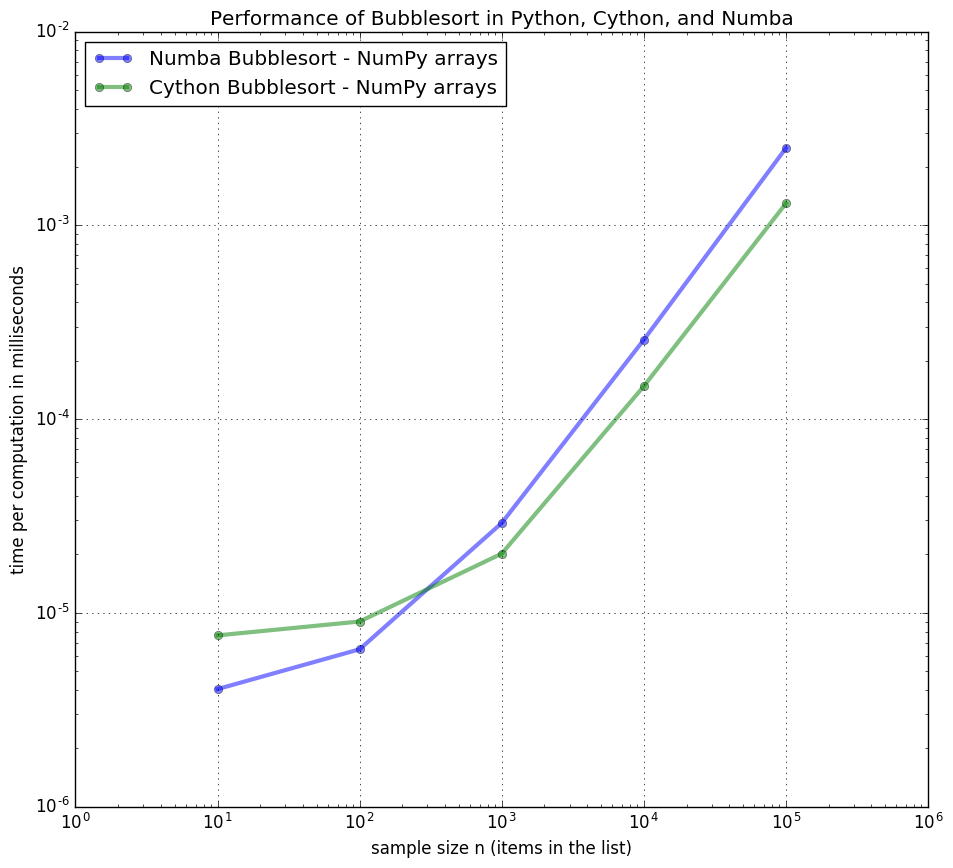

+----------+----------------------------------+-------------------+-----------------------+
| n=100000 | bubblesort function              | time in millisec. | rel. performance gain |
+----------+----------------------------------+-------------------+-----------------------+
|          | Numba Bubblesort - NumPy arrays  |        0.25       |          1.0          |
|          | Cython Bubblesort - NumPy arrays |        0.13       |          1.93         |
+----------+----------------------------------+-------------------+-----------------------+


In [54]:
title = 'Performance of Bubblesort in Python, Cython, and Numba'

labels = {'python_bubblesort':'(C)Python Bubblesort - Python lists', 
          'python_bubblesort_ary':'(C)Python Bubblesort - NumPy arrays',  
          'cython_bubblesort': 'Cython Bubblesort - NumPy arrays',
          'numba_bubblesort': 'Numba Bubblesort - NumPy arrays'
          }

ranked_by_time = sorted([(time[1][-1],time[0]) for time in timings.items()], reverse=True)

print_sysinfo()
plot(timings, title, [l for t,l in ranked_by_time], labels, orders_n)
summary_table(ranked_by_time)

Note that the relative results also depend on what version of Python, Cython, Numba, and NumPy you are using. Also, the compiler choice for installing NumPy can account for differences in the results.  

<br>
<br>